In [273]:
import pickle

import jax
import jax.numpy as jnp
import numpy as np

In [274]:
PICKLE_PATH = "model_best.pkl"

with open(PICKLE_PATH, "rb") as f:
    p = pickle.load(f)

xi_emb = jnp.asarray(p["xi_emb"], dtype=jnp.float32)
eta = jnp.asarray(p["eta"], dtype=jnp.float32)
a = jnp.asarray(p["a_v"], dtype=jnp.float32)
c = jnp.asarray(p["c"], dtype=jnp.float32)
W_out = jnp.asarray(p["W_out"], dtype=jnp.float32)
b_out = jnp.asarray(p["b_out"], dtype=jnp.float32)


In [275]:
import model_energy_train as model_energy

params = {
    "xi_emb": xi_emb,
    "eta": eta,
    "a_v": a,
    "c": c,
    "W_out": W_out,
    "b_out": b_out,
    "b_att": jnp.zeros((model_energy.Cfg.L,))
}


def run_inference(ctx_tokens):
    ctx_bits = jnp.asarray(ctx_tokens, dtype=jnp.int32)
    (V_T, H_att_T, H_hopf_T), traj = model_energy.run_model_inference_steps(ctx_bits, params)
    return traj


# randomly sample n 8-bit bit sequences from random bits
key = jax.random.PRNGKey(3)
# arr = jax.random.bernoulli(key, p=0.5, shape=(4, 8)).astype(jnp.int32)
arr = jnp.array([
    [1, 1, 0, 0, 1, 0, 1, 0],
    [0, 1, 0, 0, 0, 1, 1, 0],
    [1, 0, 1, 1, 0, 0, 0, 1],
    [0, 0, 0, 1, 1, 0, 1, 1],
])

traj = run_inference(arr)

/var/folders/m6/6m23rnw56mv9dfr3gm4bbjhw0000gn/T/ipykernel_94218/2186182361.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues', n_lines)


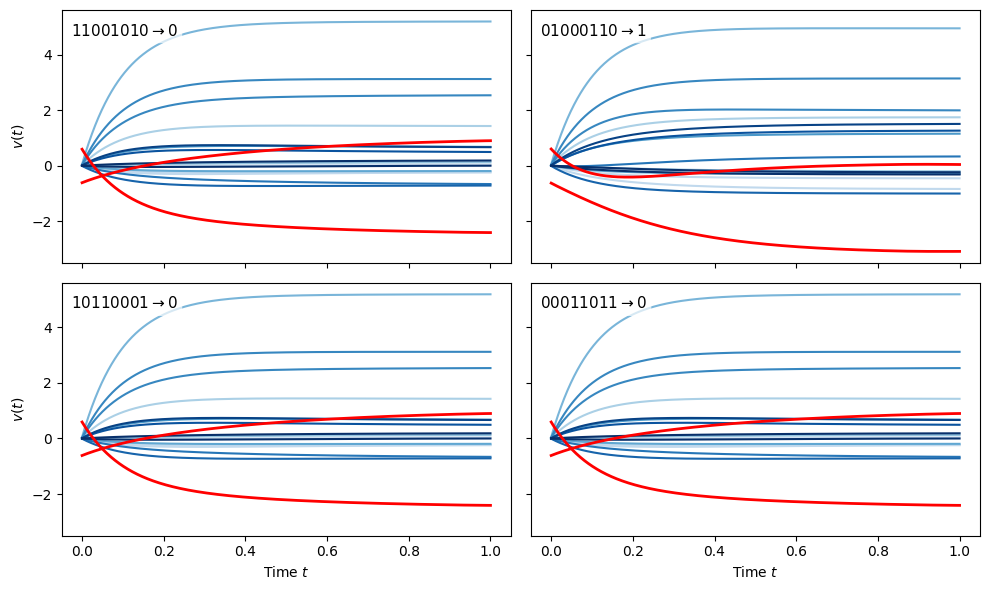

In [277]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import jax.numpy as jnp

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), sharex=True, sharey=True)

# Create the colormap
n_lines = traj['V'].shape[-1]
cmap = cm.get_cmap('Blues', n_lines)
colors = cmap(jnp.linspace(0.2, 1.0, n_lines))  # start from lighter blue

for i in range(4):
    visible_traj = traj['V'][:, i, :]  # (n_steps, D)
    logits = model_energy.logits_from_v(params, visible_traj)
    predicted_token = jnp.argmax(logits[-1], axis=-1)
    ax = axs[i // 2, i % 2]
    ts = jnp.linspace(0, model_energy.Cfg.T_final, model_energy.Cfg.n_steps)

    # Plot each dimension trajectory in a blue gradient
    for d in range(visible_traj.shape[-1]):
        ax.plot(ts, visible_traj[:, d], color=colors[d])

    # plot logits
    ax.plot(ts, jnp.asarray(logits[:, 0]), color='red', linestyle='-', linewidth=2.0, label='Predicted token logit')
    ax.plot(ts, jnp.asarray(logits[:, 1]), color='red', linestyle='-', linewidth=2.0, label='Predicted token logit')

    # Place the text title inside the plot (top-left)
    ax.text(0.02, 0.95,
            f'${"".join([str(x) for x in arr[i].tolist()])} \\rightarrow {predicted_token}$',
            transform=ax.transAxes, fontsize=11, va='top', ha='left',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none'))

axs[1, 1].set_xlabel('Time $t$')
axs[1, 0].set_xlabel('Time $t$')
axs[0, 0].set_ylabel('$v(t)$')
axs[1, 0].set_ylabel('$v(t)$')

plt.tight_layout()
plt.show()


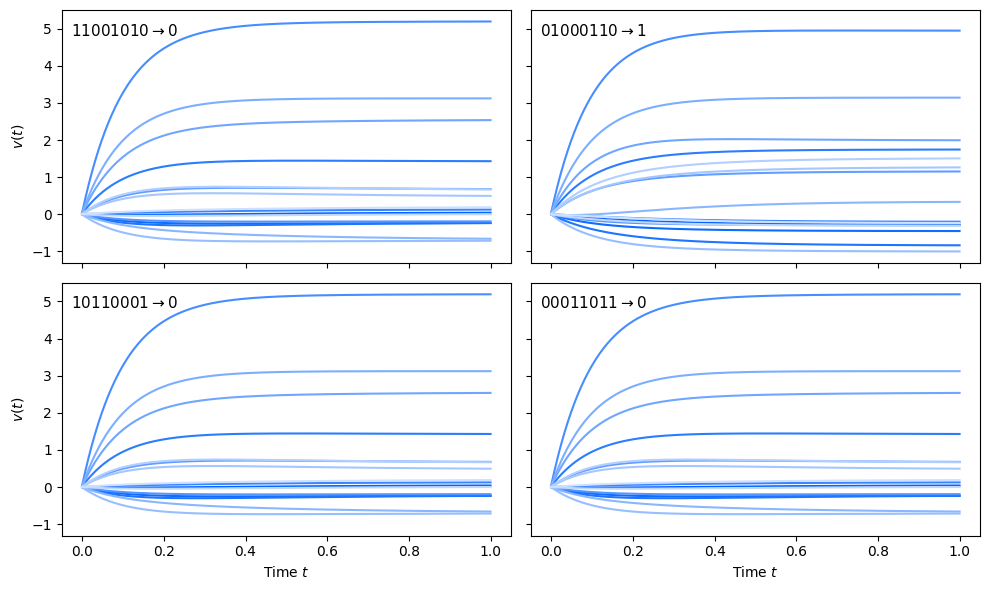

In [278]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), sharex=True, sharey=True)

# --- Generate shades of the same base color (#0364FF) using NumPy floats ---
base_color = np.array(mcolors.to_rgb("#0364FF"))  # (3,) floats in [0,1]
n_lines = int(traj['V'].shape[-1])
ws = np.linspace(0.0, 0.8, n_lines)              # blend factor toward white
shades = [tuple(((1.0 - w) * base_color + w * 1.0).tolist()) for w in ws]  # list of (r,g,b)

for i in range(4):
    visible_traj = traj['V'][:, i, :]  # (n_steps, D)
    logits = model_energy.logits_from_v(params, visible_traj[-1])
    predicted_token = jnp.argmax(logits, axis=-1)
    ax = axs[i // 2, i % 2]

    ts = np.linspace(0, model_energy.Cfg.T_final, model_energy.Cfg.n_steps)  # NumPy for Matplotlib

    # plot each line with a different shade of #0364FF
    for d in range(visible_traj.shape[-1]):
        ax.plot(ts, np.asarray(visible_traj[:, d]), color=shades[d])

    # put the title text inside the subplot (top-left)
    ax.text(
        0.02, 0.95,
        f'${"".join([str(x) for x in arr[i].tolist()])} \\rightarrow {predicted_token}$',
        transform=ax.transAxes, fontsize=11, va='top', ha='left',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.0, edgecolor='none'),
    )

axs[1, 1].set_xlabel('Time $t$')
axs[1, 0].set_xlabel('Time $t$')
axs[0, 0].set_ylabel('$v(t)$')
axs[1, 0].set_ylabel('$v(t)$')

plt.tight_layout()
plt.show()


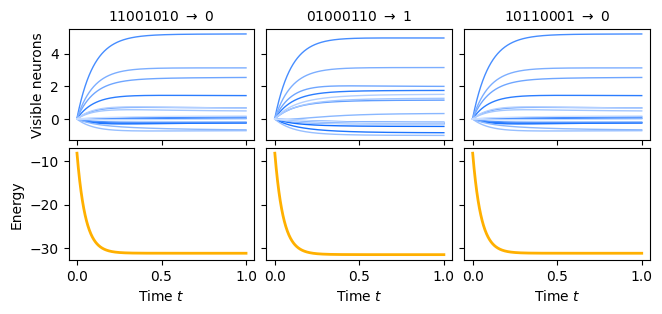

In [279]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import jax.numpy as jnp

# --- config / helpers ---
T_final = float(model_energy.Cfg.T_final)
n_steps = int(model_energy.Cfg.n_steps)
ts = np.linspace(0.0, T_final, n_steps)

# first three contexts
cols = 3
ctx_idx = [0, 1, 2]

# colors: generate D shades of #0364FF
base_color = np.array(mcolors.to_rgb("#0364FF"))
D = int(traj['V'].shape[-1])
ws = np.linspace(0.0, 0.8, D)  # blend toward white
shades = [tuple(((1.0 - w) * base_color + w * 1.0).tolist()) for w in ws]

fig, axs = plt.subplots(nrows=2, ncols=cols, figsize=(6.5, 3), sharex=True, sharey='row')
for c, i in enumerate(ctx_idx):
    # --- data slices for context i ---
    V_traj = np.asarray(traj['V'][:, i, :])              # (n_steps, D)
    E_traj = np.asarray(traj['energy'][:, i])            # (n_steps,)
    # prediction from final v(T)
    logits = model_energy.logits_from_v(params, V_traj[-1])
    pred = int(jnp.argmax(logits))
    # make a neat bitstring label
    bits = "".join(str(int(b)) for b in np.asarray(arr[i]).tolist())

    # --- top: v(t) trajectories ---
    ax_top = axs[0, c]
    for d in range(D):
        ax_top.plot(ts, V_traj[:, d], color=shades[d], linewidth=1.0)
    ax_top.set_ylabel(r'Visible neurons' if c == 0 else None)
    # column label
    ax_top.set_title(fr'${bits}\ \rightarrow\ {pred}$', fontsize=10)

    # --- bottom: energy ---
    ax_bot = axs[1, c]
    ax_bot.plot(ts, E_traj, color='#FFB000', linewidth=2.0)
    if c == 0:
        ax_bot.set_ylabel(r'Energy')

# shared x label on bottom row
for c in range(cols):
    axs[1, c].set_xlabel(r'Time $t$')

# tidy layout
plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=0.2)
plt.savefig('parity_inference.pdf', bbox_inches='tight')
plt.show()
